# Imports

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile as zf
import re
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
print("Done!")

Done!


In [40]:
!pip install bert-for-tf2
!pip install sentencepiece

In [47]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import bert
from bert import tokenization
from transformers import AutoTokenizer

In [19]:

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input/test.csv.zip
input/test_labels.csv.zip
input/train.csv.zip
input/sample_submission.csv.zip


In [23]:
train = pd.read_csv('input/train.csv.zip')
test_data = pd.read_csv('input/test.csv.zip')
test_labels = pd.read_csv('input/test_labels.csv.zip')

In [26]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [28]:
column_list = [f for f in train.columns if train.dtypes[f] != 'object']
df = pd.DataFrame(columns=column_list)
for col in column_list:
    df.loc[0,col] = train[train[col] == 1][col].sum()
df['non_hate'] = train.shape[0] - df.sum(axis=1)    

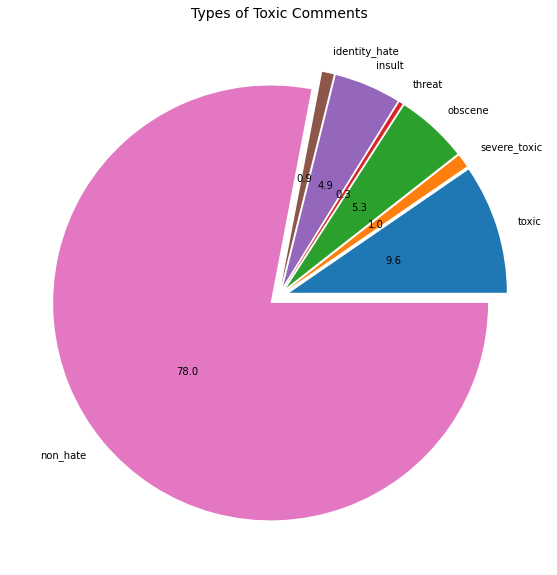

In [29]:
pie, ax = plt.subplots(figsize=[12,10])
labels = df.keys()
plt.pie(x=df.values[0], autopct="%.1f", explode=[0.05]*len(df.values[0]), labels=labels, pctdistance=0.5)
plt.title("Types of Toxic Comments", fontsize=14);
pie.savefig("ToxicCommentsChart.png")

In [30]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [31]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [32]:
df = train.drop(columns=['id'], axis=1)

# Preprocessing

## Cleaning

In [33]:
def clean_comment(comment):
    # Removing the @
    comment = re.sub(r"@[A-Za-z0-9]+", ' ', comment)
    # Removing the URL links
    comment = re.sub(r"https?://[A-Za-z0-9./]+", ' ', comment)
    # Keeping only letters
    comment = re.sub(r"[^a-zA-Z.!?']", ' ', comment)
    # Removing additional whitespaces
    comment = re.sub(r" +", ' ', comment)
    return comment

In [34]:
df['comment_text'] = df['comment_text'].apply(lambda x: clean_comment(x))

In [35]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,Hey man I'm really not trying to edit war. It'...,0,0,0,0,0,0
3,More I can't make any real suggestions on imp...,0,0,0,0,0,0
4,You sir are my hero. Any chance you remember w...,0,0,0,0,0,0


In [36]:
data_clean = df.comment_text.values
data_labels = df.drop(columns=['comment_text'],axis=1).values

## Tokenization

In [48]:
FullTokenizer = tokenization.FullTokenizer # bert.tok...
#FullTokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

AttributeError: module 'bert.tokenization' has no attribute 'FullTokenizer'

In [18]:
def encode_sentence(sent):
    return ["[CLS]"] + tokenizer.tokenize(sent)[:510] + ["[SEP]"]

In [19]:
data_inputs = [encode_sentence(sentence) for sentence in data_clean]

## Dataset Creation

In [20]:
def get_ids(tokens):
    return tokenizer.convert_tokens_to_ids(tokens)

def get_mask(tokens):
    return np.char.not_equal(tokens, "[PAD]").astype(int)

def get_segments(tokens):
    seg_ids = []
    current_seg_id = 0
    for tok in tokens:
        seg_ids.append(current_seg_id)
        if tok == "[SEP]":
            current_seg_id = 1-current_seg_id # turns 1 into 0 and vice versa
    return seg_ids

In [21]:
data_with_len = [[sent, data_labels[i], len(sent)]
                 for i, sent in enumerate(data_inputs)]
random.shuffle(data_with_len)
data_with_len.sort(key=lambda x: x[2])
sorted_all = [([get_ids(sent_lab[0]),
                get_mask(sent_lab[0]),
                get_segments(sent_lab[0])],
               sent_lab[1])
              for sent_lab in data_with_len if sent_lab[2] > 7]

In [22]:
# A list is a type of iterator so it can be used as generator for a dataset
all_dataset = tf.data.Dataset.from_generator(lambda: sorted_all,
                                             output_types=(tf.int32, tf.int32))

In [23]:
BATCH_SIZE = 32
all_batched = all_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=((3, None), (6)),
                                       padding_values=(0, 0))

In [24]:
NB_BATCHES = math.ceil(len(sorted_all) / BATCH_SIZE)
NB_BATCHES_TEST = NB_BATCHES // 10
all_batched.shuffle(NB_BATCHES)
test_dataset = all_batched.take(NB_BATCHES_TEST)
train_dataset = all_batched.skip(NB_BATCHES_TEST)

# Model Building

In [25]:
class DCNNBERTEmbedding(tf.keras.Model):
    
    def __init__(self,
                 nb_filters=50,
                 FFN_units=512,
                 nb_classes=6,
                 dropout_rate=0.1,
                 name="dcnn"):
        super(DCNNBERTEmbedding, self).__init__(name=name)
        
        self.bert_layer = hub.KerasLayer(
            "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
            trainable=False)

        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size=2,
                                    padding="valid",
                                    activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,
                                     kernel_size=3,
                                     padding="valid",
                                     activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,
                                      kernel_size=4,
                                      padding="valid",
                                      activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
#        if nb_classes == 2:
        self.last_dense = layers.Dense(units=nb_classes,
                                           activation="sigmoid")
#        else:
#            self.last_dense = layers.Dense(units=nb_classes,
#                                           activation="softmax")
    
    def embed_with_bert(self, all_tokens):
        _, embs = self.bert_layer([all_tokens[:, 0, :],
                                   all_tokens[:, 1, :],
                                   all_tokens[:, 2, :]])
        return embs

    def call(self, inputs, training):
        x = self.embed_with_bert(inputs)

        print(x.shape)

        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1, x_2, x_3], axis=-1) # (batch_size, 3 * nb_filters)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

# Model Training

In [26]:
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 6

DROPOUT_RATE = 0.5

BATCH_SIZE = 32
NB_EPOCHS = 2

In [27]:
Dcnn = DCNNBERTEmbedding(nb_filters=NB_FILTERS,
                         FFN_units=FFN_UNITS,
                         nb_classes=NB_CLASSES,
                         dropout_rate=DROPOUT_RATE)

In [28]:
Dcnn.compile(loss="binary_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [29]:
checkpoint_path = "./"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!!")

In [30]:
class MyCustomCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        ckpt_manager.save()
        print("Checkpoint saved at {}.".format(checkpoint_path))

In [31]:
Dcnn.fit(train_dataset,
         epochs=NB_EPOCHS,
         callbacks=[MyCustomCallback()])

Epoch 1/2
(None, None, 768)
(None, None, 768)
4399/4399 [==============================] - 589s 130ms/step - loss: 0.0708 - accuracy: 0.8316
Checkpoint saved at ./.
Epoch 2/2
4399/4399 [==============================] - 557s 126ms/step - loss: 0.0511 - accuracy: 0.9461
Checkpoint saved at ./.


In [32]:
Dcnn.save('Bert_Dcnn_model1',save_format='tf')

(None, None, 768)
(None, None, 768)
(None, None, 768)
(None, None, 768)
(None, None, 768)
(None, None, 768)
(None, None, 768)


In [33]:
new_model = load_model('Bert_Dcnn_model1')

# Evaluation

In [34]:
results = Dcnn.evaluate(test_dataset)
print(results)

(None, None, 768)
488/488 [==============================] - 13s 24ms/step - loss: 0.1241 - accuracy: 0.9891
[0.12407687306404114, 0.9891137480735779]
